In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import generate_figure, test_partial
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-04-17 15:57:07.790445: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-17 15:57:07.790480: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Load data (visual)
data1 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/geneExp_filtered.csv")
data2 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/efeature_filtered.csv")
sample_names1 = data1.columns[1:]
sample_names2 = np.array(data2)[:, 0]
assert (sample_names1 == sample_names2).all()
data1 = np.transpose(np.array(data1)[:, 1:])
data2 = np.array(data2)[:, 3:]
meta = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/20200711_patchseq_metadata_mouse.csv")[['transcriptomics_sample_id', 't_type']]
meta = np.array(meta)
meta_idx = [np.argwhere(meta[:, 0] == sample_names1[i])[0][0] for i in range(sample_names1.shape[0])]
type1 = type2 = np.array([x.split()[0] for x in meta[meta_idx, 1]])

# # Load data (motor)
# data1 = pd.read_csv("../data/scMNC/mouse_motor_cortex/data/geneExp_filtered.csv")
# data2 = pd.read_csv("../data/scMNC/mouse_motor_cortex/data/efeature_filtered.csv")
# sample_names1 = data1.columns[1:]
# assert ((data1.shape[1] - 1) == data2.shape[0])
# data1 = np.transpose(np.array(data1)[:, 1:])
# data2 = np.array(data2)
# meta = pd.read_excel("../data/scMNC/mouse_motor_cortex/data/motor_meta_data.xlsx")[['Cell', 'RNA family']]
# meta = np.array(meta)
# meta_idx = [np.argwhere(meta[:, 0] == sample_names1[i])[0][0] for i in range(sample_names1.shape[0])]
# type1 = type2 = np.array([x.split()[0] for x in meta[meta_idx, 1]])

# Sampling
data_col_idx = np.random.choice(range(data1.shape[0]), 500, replace=False)
data1, data2, type1, type2 = (x[data_col_idx] for x in (data1, data2, type1, type2))
# data1_feat_idx = np.random.choice(range(data1.shape[1]), 20, replace=False)
# data1 = data1[:, data1_feat_idx]
# data2_feat_idx = np.random.choice(range(data2.shape[1]), 20, replace=False)
# data2 = data2[:, data2_feat_idx]

# Labels
labels = [type1, type2]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
dataset = [data1, data2]

# Utility
positivize = lambda X: [(1 + preprocessing.scale(1 + x)) / 2 for x in X]

In [4]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 2
batch_size = 32
pca_dim = [32, None]

# ComManDo

In [5]:
cm = ComManDo(output_dim=reduced_dim, epoch_DNN=2000, log_DNN=500, batch_size=batch_size, pca_dim=pca_dim)
cm_data = cm.fit_transform(dataset=dataset)
cm_data_half = ComManDo(output_dim=reduced_dim, epoch_DNN=2000, log_DNN=500, batch_size=batch_size, pca_dim=pca_dim, P=half_priors, match_result=cm.match_result, PF_Ratio=.5).fit_transform(dataset=dataset)
cm_data_none = ComManDo(output_dim=reduced_dim, epoch_DNN=2000, log_DNN=500, batch_size=batch_size, pca_dim=pca_dim, P=none_priors, match_result=cm.match_result, PF_Ratio=0).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1302)
Dataset 1: (500, 39)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.0951 alpha:0.0649
epoch:[1000/2000] err:0.1112 alpha:0.0762
epoch:[1500/2000] err:0.1207 alpha:0.0834
epoch:[2000/2000] err:0.1258 alpha:0.0880
Finished Matching!
---------------------------------
Performing NLMA
epoch:[500/2000]: loss:1.195792
Finished Mapping!
---------------------------------
ComManDo Done!

Distance: 0.2424255479995736
Correspondence: 9.102403939999931
Mapping: 47.72091725200016
Total: 57.06574673999967
use random seed: 666
Shape of Raw data
Dataset 0: (500, 1302)
Dataset 1: (500, 39)
---------------------------------
Performing NLMA
epoch:[500/2000]: loss:1.225692
Finished Mapping!
---------------------------------
ComManDo Done!

Distance: 0.2486514829997759
Correspondence: 0.046909695000067586
Mapping: 44.66235960299991
Total: 44.95792078099976
use random seed: 

# Comparison Methods

In [6]:
# Unioncom
uc = ComManDo(project_mode='tsne', output_dim=reduced_dim)
uc_data = uc.fit_transform(dataset=positivize(dataset))

# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
nlma_data_half, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim, corr=half_priors)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1302)
Dataset 1: (500, 39)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.0951 alpha:0.0649
epoch:[1000/2000] err:0.1112 alpha:0.0762
epoch:[1500/2000] err:0.1207 alpha:0.0834
epoch:[2000/2000] err:0.1258 alpha:0.0880
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[10/100]: loss:4.973971, align_loss:0.139430
epoch:[20/100]: loss:4.788982, align_loss:0.211766
epoch:[30/100]: loss:4.781787, align_loss:0.215942
epoch:[40/100]: loss:4.726677, align_loss:0.239585
epoch:[50/100]: loss:4.754642, align_loss:0.227515
epoch:[60/100]: loss:4.460799, align_loss:0.230644
epoch:[70/100]: loss:4.299938, align_loss:0.217825
epoch:[80/100]: loss:4.797233, align_loss:0.215700
epoch:[90/100]: loss:4.604967, align_loss:0.207921
epoch:[100/100]: loss:4.086790, align_loss:0.194069
Done
---------------------------------
ComManDo Done!
D

# Figure Generation

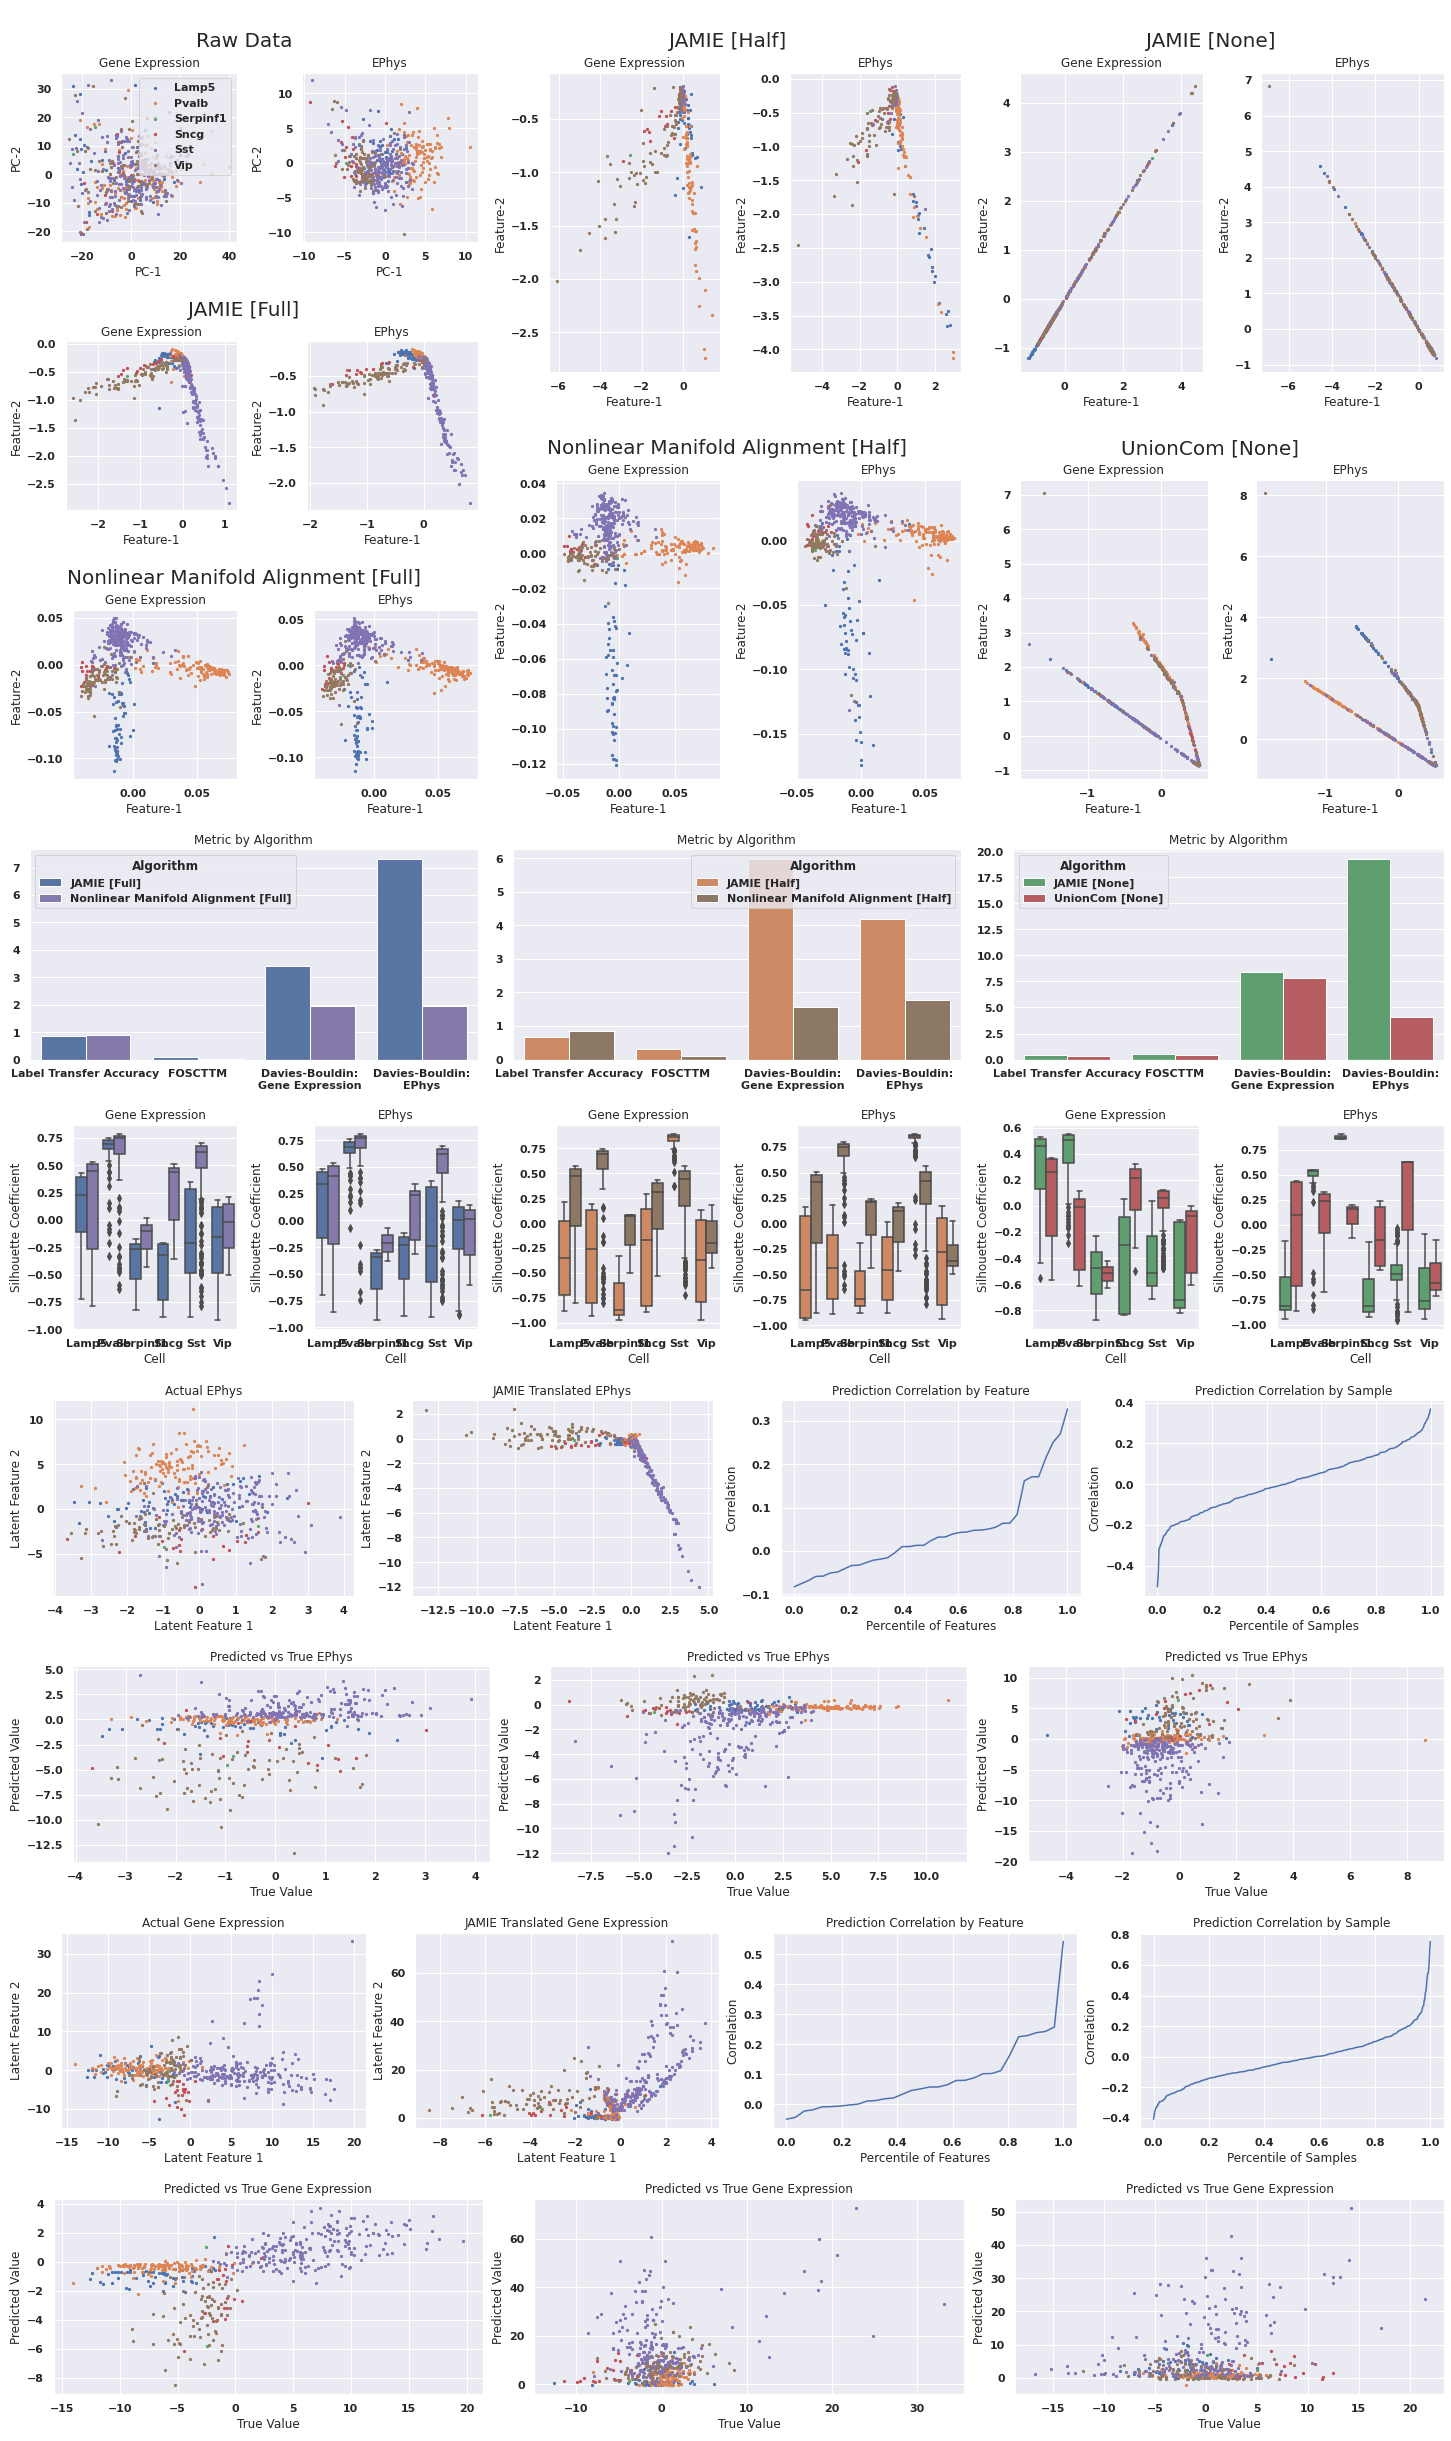

In [7]:
#%%capture --no-display
params = {
    'dataset_names': ['Gene Expression', 'EPhys'],
    'integrated_data': [cm_data, cm_data_half, cm_data_none, uc_data, nlma_data, nlma_data_half],
    'integrated_alg_names': ['JAMIE [Full]', 'JAMIE [Half]', 'JAMIE [None]', 'UnionCom [None]', 'Nonlinear Manifold Alignment [Full]', 'Nonlinear Manifold Alignment [Half]'],
    'alg_groups': [0, 1, 2, 2, 0, 1],
    'raw_data_group': 0,
    'integrated_rows': 1,
    'scale': 20,
    # 'integrated_use_pca': True,
    'skip_partial': True,
    'skip_nn': True,
    'skip_simple': True,
}
generate_figure(cm, dataset, labels, **params)